# Principal Component Analysis (PCA) on Employee_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [26]:
%pylab inline
import sys                          
import pandas as pd, numpy as np             # Data manipulation 
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['xticks', 'yticks']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [27]:
dataset_limit = 10000
keep_dates = False

# load the data file within a Pandas dataframe (change the dataset name for a different project)
df = pd.read_excel('Benefit_factor.xlsx', index_col=0)
df.head()

,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,...,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
ben01,,,,,,,,,,,,,,,,,,,,,
4.0,1,1.0,4,7,1.0,1.0,4.0,7,7.0,7.0,...,6,7,1.0,7.0,4.0,6,7.0,7,4,1
1.0,6,1.0,6,6,1.0,1.0,6.0,1,1.0,6.0,...,1,6,4.0,6.0,6.0,4,6.0,2,4,4
6.0,4,7.0,7,7,7.0,7.0,2.0,4,7.0,7.0,...,7,7,6.0,7.0,7.0,7,7.0,7,7,7
3.0,3,2.0,6,6,2.0,4.0,6.0,4,6.0,6.0,...,2,6,2.0,6.0,1.0,6,6.0,5,4,6
4.0,6,2.0,5,6,4.0,5.0,1.0,5,5.0,6.0,...,6,6,3.0,6.0,3.0,5,6.0,6,4,6


In [28]:
# make a copy of the original dataframe
df_orig = df.copy()    

# dropping now some non relevant fields
#df = df.drop(["gender", "minority", "jobtime"], axis=1)

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 349
   Columns: 22 (22 num, 0 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [29]:
## TO REMOVE THERE'S NO DATES

columns_to_drop = []
if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

Get rid of the columns that contain too many unique values

In [30]:
## TO REMOVE THERE'S NO CAT VARIABLES

DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print("Dropping feature %s with %s values" % (feature, nu))
        columns_to_drop.append(feature)

We then need to impute missing values (or drop the records)

In [31]:
impute = True

if impute:
    # Use mean for numerical features
    for feature in numerical_columns:
        v = df[feature].mean()
        if np.isnan(v):
            v = 0
        print("Filling %s with %s" % (feature, v))
        df[feature] = df[feature].fillna(v)

    # Use mode for categorical features
    for feature in categorical_columns:
        v = df[feature].value_counts().index[0]
        df[feature] = df[feature].fillna(v)

else:        
    # drop records
    df.dropna(inplace=True)


Filling ben02 with 4.934097421203439
Filling ben03 with 4.115606936416185
Filling ben04 with 5.954154727793696
Filling ben05 with 5.9054441260744985
Filling ben06 with 4.675287356321839
Filling ben07 with 4.662790697674419
Filling ben08 with 5.195965417867435
Filling ben09 with 5.469914040114613
Filling ben10 with 5.767241379310345
Filling ben11 with 6.028735632183908
Filling ben12 with 5.822349570200573
Filling ben13 with 6.2881844380403455
Filling ben14 with 4.773638968481375
Filling ben15 with 5.756446991404012
Filling ben16 with 3.965217391304348
Filling ben17 with 6.195402298850575
Filling ben18 with 4.6938775510204085
Filling ben19 with 5.902578796561604
Filling ben20 with 5.505747126436781
Filling ben21 with 5.862464183381089
Filling ben22 with 5.0687679083094554
Filling ben23 with 5.598853868194842


Drop the columns

In [32]:
## TO REMOVE SINCE THERE'S NO CAT VARIABLES

print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: []


For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [33]:
## TO REMOVE THERE'S NO CAT VARIABLES

# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            if sys.version_info > (3,0):
                dummy_name = '%s_value_%s' % (feature, dummy_value)
            else:
                dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(df)

In [34]:
df

,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,...,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
ben01,,,,,,,,,,,,,,,,,,,,,
4.0,1,1.0,4,7,1.0,1.0,4.0,7,7.0,7.0,...,6,7,1.0,7.0,4.0,6,7.0,7,4,1
1.0,6,1.0,6,6,1.0,1.0,6.0,1,1.0,6.0,...,1,6,4.0,6.0,6.0,4,6.0,2,4,4
6.0,4,7.0,7,7,7.0,7.0,2.0,4,7.0,7.0,...,7,7,6.0,7.0,7.0,7,7.0,7,7,7
3.0,3,2.0,6,6,2.0,4.0,6.0,4,6.0,6.0,...,2,6,2.0,6.0,1.0,6,6.0,5,4,6
4.0,6,2.0,5,6,4.0,5.0,1.0,5,5.0,6.0,...,6,6,3.0,6.0,3.0,5,6.0,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.0,2,2.0,5,5,2.0,3.0,4.0,4,3.0,6.0,...,4,4,2.0,6.0,3.0,5,2.0,4,2,4
1.0,7,7.0,7,7,4.0,7.0,7.0,7,7.0,7.0,...,1,7,7.0,7.0,7.0,7,4.0,7,7,7
4.0,5,7.0,7,7,7.0,7.0,7.0,7,7.0,7.0,...,7,7,3.0,7.0,2.0,7,7.0,4,4,7


<Axes: >

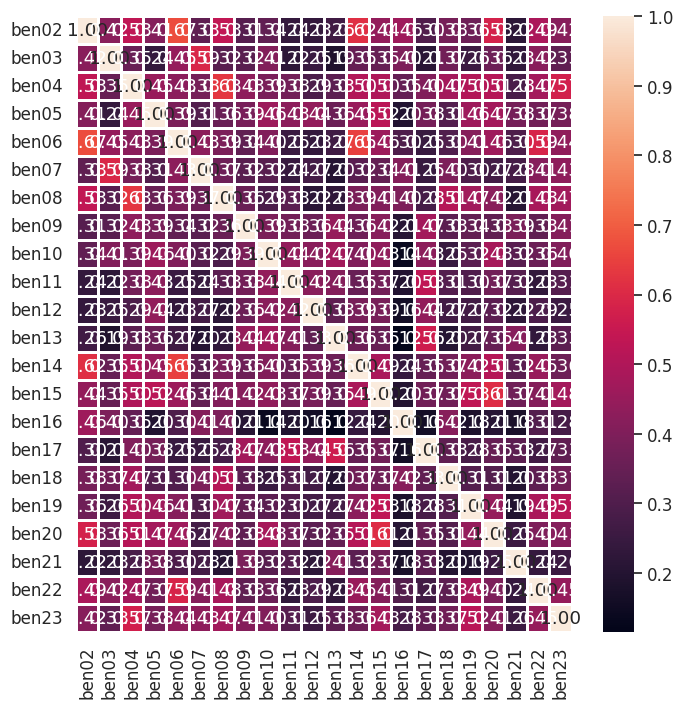

In [35]:
# Heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

Finally, we rescale the whole data

In [36]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(df)
X_std = ss.transform(df)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [37]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

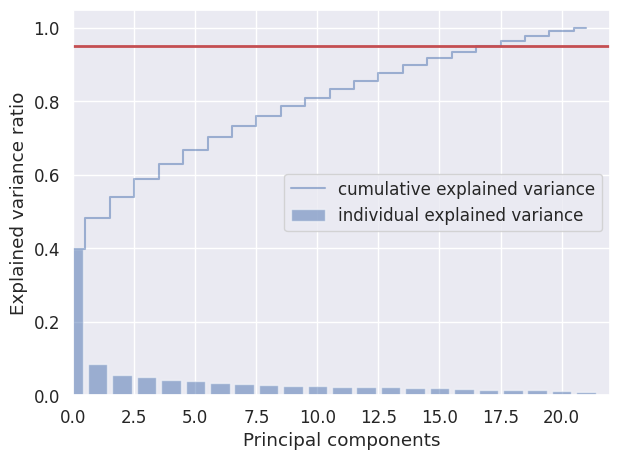

In [38]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()


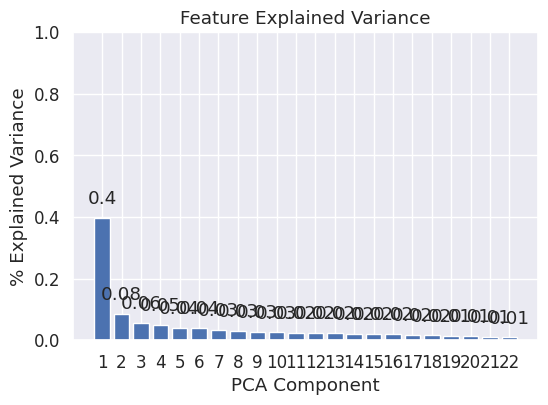

In [39]:
#Bar plot of explained_variance
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(sklearn_pca.n_components_) + 1,
    height = sklearn_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, sklearn_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(sklearn_pca.n_components_) + 1)
ax.set_ylim(0, 1)
ax.set_title('Feature Explained Variance')
ax.set_xlabel('PCA Component')
ax.set_ylabel('% Explained Variance');

In [40]:
# Show data from the chart
print ("Component explained variance:")
variances = pd.DataFrame(sklearn_pca.explained_variance_ratio_, columns=['Variances'])
variances_cum = pd.DataFrame(sklearn_pca.explained_variance_ratio_.cumsum(), columns=['Cumulative'])
frames = [variances, variances_cum] 
df_var = pd.concat(frames, sort=False, axis=1)
df_var

Component explained variance:


,Variances,Cumulative
0,0.397404,0.397404
1,0.084602,0.482007
2,0.056484,0.538491
3,0.049250,0.587740
4,0.040899,0.628639
5,0.039460,0.668099
6,0.033764,0.701863
7,0.031464,0.733327
8,0.027493,0.760820
9,0.025616,0.786436


In [41]:
## ADDED THIS TO SEE THE RATIOS - there's so many values in the dataset that we can't see the ratios
## We can use this to justify which factors to keep and add a filter to only show the ones above 1

# Display the eigenvalues and their ratios
eigenvalues = sklearn_pca.explained_variance_
eigenvalues_ratio = eigenvalues / eigenvalues.sum()
cumulative_ratio = eigenvalues_ratio.cumsum()

eigenvalues_df = pd.DataFrame({
    'Eigenvalues': eigenvalues,
    'Eigenvalues Ratio': eigenvalues_ratio,
    'Cumulative Ratio': cumulative_ratio
})
print(eigenvalues_df)

    Eigenvalues  Eigenvalues Ratio  Cumulative Ratio
0      8.768015           0.397404          0.397404
1      1.866602           0.084602          0.482007
2      1.246218           0.056484          0.538491
3      1.086604           0.049250          0.587740
4      0.902373           0.040899          0.628639
5      0.870605           0.039460          0.668099
6      0.744944           0.033764          0.701863
7      0.694193           0.031464          0.733327
8      0.606589           0.027493          0.760820
9      0.565167           0.025616          0.786436
10     0.532587           0.024139          0.810575
11     0.514220           0.023307          0.833882
12     0.502655           0.022782          0.856664
13     0.466884           0.021161          0.877825
14     0.445377           0.020186          0.898012
15     0.429766           0.019479          0.917491
16     0.381387           0.017286          0.934777
17     0.341167           0.015463          0.

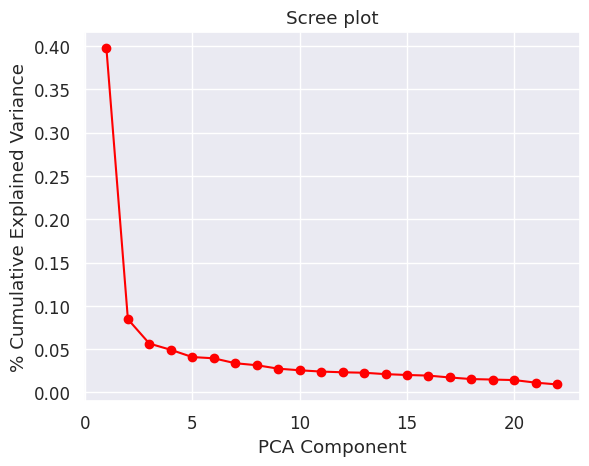

In [42]:
# Scree plot 
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)
 
plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [43]:
## CHANGED THE VARIANCE_TO_KEEP to the cummulative of the 4 first factors

VARIANCE_TO_KEEP = 0.60
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

Number of components to keep to retain 60.0% of the variance: 4 out of the original 22


Let's run the PCA again but with a limited number of components this time

In [44]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

In [45]:
# Shows loading factors = correlations between variables and factors
print ("Loading factors:")

dfloading=pd.DataFrame(
    data    = sklearn_pca_final.components_,
    columns = df.columns,
)

index_list=[]
for n in range(retained_components_number):
    index_list.append("PC"+str(n+1))

dfloading.index = index_list
dfloading

Loading factors:


,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,...,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
PC1,0.238509,0.195152,0.252708,0.225445,0.234477,0.197417,0.224187,0.209874,0.217165,0.193487,...,0.240841,0.243444,0.153919,0.199785,0.197271,0.215765,0.235656,0.163960,0.223812,0.228264
PC2,-0.248879,-0.222282,-0.092228,0.161007,-0.199813,-0.202948,-0.216600,0.186549,0.216424,0.302232,...,-0.032991,0.066454,-0.316630,0.347902,-0.155611,-0.049053,0.015605,0.214897,-0.202560,-0.072781
PC3,-0.168240,0.316195,-0.060165,-0.156388,-0.199086,0.385015,-0.003013,0.165807,0.000263,0.144166,...,-0.221932,-0.213219,0.402079,0.180419,0.285334,-0.304581,-0.296879,0.158453,-0.112330,-0.042447
PC4,-0.124559,-0.357348,0.312957,0.010721,-0.364573,-0.190863,0.399573,0.051302,-0.234068,0.156324,...,-0.210327,0.012289,0.070026,0.128419,0.323808,0.251276,-0.055334,-0.224644,-0.098690,0.209580


Each variable can be expressed as a lineal combination of Factors. For instance:
educ = 0.452923*PC1 -0.125929*PC2 -0.042881*PC3


Now we hide values lower than 0.2 or 0.3 to display better the relations

In [46]:
# Hide values so that it is clearer
dfloading2 = dfloading.where(abs(dfloading) > 0.3  , "")
dfloading2

,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,...,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
PC1,,,,,,,,,,,...,,,,,,,,,,
PC2,,,,,,,,,,0.302232,...,,,-0.31663,0.347902,,,,,,
PC3,,0.316195,,,,0.385015,,,,,...,,,0.402079,,,-0.304581,,,,
PC4,,-0.357348,0.312957,,-0.364573,,0.399573,,,,...,,,,,0.323808,,,,,


In [47]:
# For display reasons, we don't show all components if more than 50 (same for input variables)
n_components_to_show = min(50, sklearn_pca_final.n_components_)
n_input_features = sklearn_pca_final.components_.shape[1]

decomp_df = pd.DataFrame(sklearn_pca_final.components_[0:n_components_to_show],
                            columns=df.columns)
if decomp_df.shape[1] > 50:
    decomp_df = decomp_df[decomp_df.columns[0:50]]

fig = plt.figure(figsize=(n_input_features, n_components_to_show))
sns.set(font_scale=1)
sns.heatmap(decomp_df, square=True, annot=True).set(title='Component Matrix: Loading factors')
sns.set(font_scale=1)

AxisError: axis 4 is out of bounds for array of dimension 0

### Communalities
In order to calculate communalities (% of information explained from each variable), we need to square the loading factors of each variable.

In [24]:
# Communalities
commun=[]

for col in dfloading.columns:
    commun.append((dfloading.iloc[0:3][col]**2).sum())
    
dfcommun = pd.DataFrame(commun,index=dfloading.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
ben16,0.285613
ben07,0.228398
ben17,0.193501
ben03,0.187473
ben13,0.179515
ben11,0.149565
ben02,0.147132
ben18,0.144546
ben20,0.143914
ben19,0.141730


/tmp/ipykernel_8665/3956447377.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=50)
/tmp/ipykernel_8665/3956447377.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xs[i], ys[i], "  " + varnames)


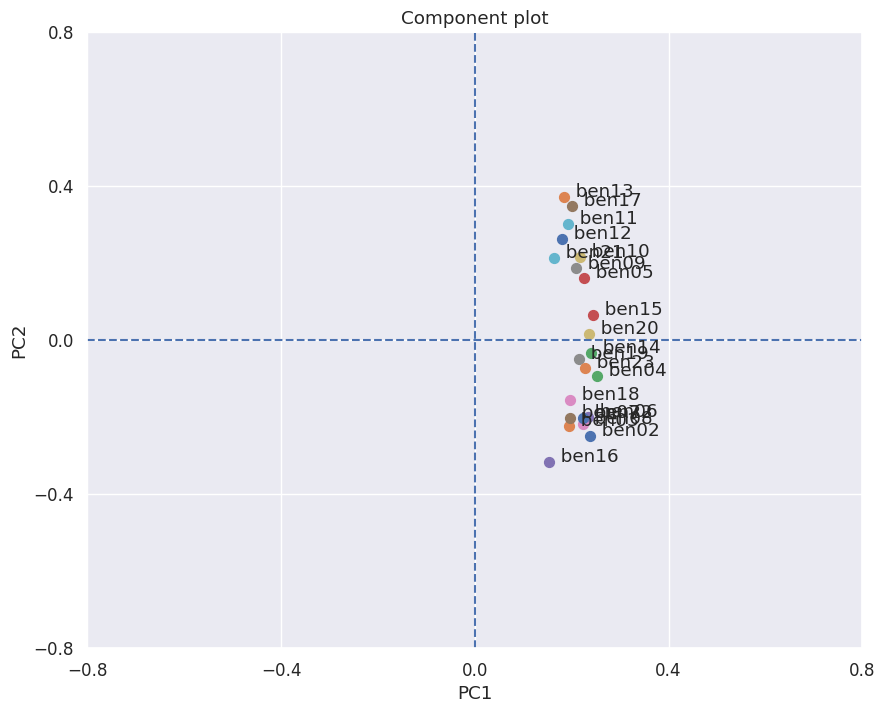

In [25]:
## NOT SURE WE SHOULD ADD THIS - there's 4 factors so we can't represent them in a 2D plot

# Get the loadings of x and y axes
dfloadT = dfloading.T

xs = dfloadT.PC1
ys = dfloadT.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(dfloading.columns):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot')
plt.savefig('Component plot.png')
plt.show()

### Visualizing projected vectors

In [ ]:
# Create dataframe of two components to display them
sklearn_pca_2 = PCA(n_components=2)
Y_sklearn_2 = sklearn_pca_2.fit_transform(X_std)
indx=np.arange(1, Y_sklearn_2.shape[0]+1)

pca_df_2 = pd.DataFrame(
    data=Y_sklearn_2, 
    columns=['PC1', 'PC2'])

sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_2, 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

In [ ]:
# and now it shows the data Projections
pca_df_2

In [ ]:
# Combine original data with components created
frames = [df_orig, pca_df_2]
dffinal = pd.concat(frames,axis=1)
dffinal.to_excel("Final.xlsx")

## Rotations

In [ ]:
from sklearn.decomposition import PCA, FactorAnalysis

n_comps = 2

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]

num_methods = np.arange(3)

for ax, (method, fa) in zip(num_methods, methods):
    fa.set_params(n_components=n_comps)
    ss = StandardScaler().fit(df)
    X_std = ss.transform(df)
    Y_sklearn = fa.fit_transform(X_std)
    
    components = fa.components_.T
    if method == "Unrotated FA":
        df_factor = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    elif method == "Varimax FA":
        df_varimax = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    else:
        df_pca = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
        

In [ ]:
print("PCA: ")
df_pca.where(abs(df_pca) > 0.3  , "")

In [ ]:
print("Unrotated Factor: ")
df_factor.where(abs(df_factor) > 0.3  , "")

In [ ]:
print("Varimax rotation: ")
df_varimax.where(abs(df_varimax) > 0.3  , "")

In [ ]:
# Represent the component plot rotated
xs = df_varimax.PC1
ys = df_varimax.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(df_varimax.T):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot varimax rotation')
plt.savefig('Component plot varimax rotation.png')
plt.show()